In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load JSON-formatted benchmarking results into a data-frame
def load(path):
    data_fd = open(path, 'r')
    data = json.load(data_fd)['results']
    data_fd.close()
    return pd.json_normalize(data)

# Get relative shift in performance on each of the metrics
def relative_diff(old, new):
    metrics = list(set(old.columns) - set(['name']))

    rel = new.copy()
    for x in metrics:
        assert (new[x].dtypes == 'float64')    
        rel[x] = new[x] / old[x]
        
    return rel

In [5]:
df_new = load('data/type-new.json')
df_old = load('data/type-old.json')

df = relative_diff(df_old, df_new)

df = df.rename(columns={
    "metrics.major-allocated (words)": "Major words allocated",
    "metrics.minor-allocated (words)": "Minor words allocated",
    "metrics.monotonic-clock (ns)": "Time"
})

metrics = [ "Major words allocated", "Minor words allocated", "Time" ]
    
# Split the benchmark names to determine the codec used and the direction
# e.g. `{ name = '/bin/hash/dec'}` -> `{ codec = 'bin'; name = 'hash'; direction = 'dec' }`
#
# NOTE: the inner 'name' component can contain '/' characters, so we partition
#       once from each side.

index = df.name
index = index.str.lstrip('/').str.partition('/')

codec = index[0]
index = index[2].str.rpartition('/')
name = index[0]
direction = index[2]

index  = pd.DataFrame({ 'codec': codec, 'name': name, 'direction': direction })
data   = df.filter(metrics)

df = pd.concat([index, data], axis=1, sort=False)
df = df[df.codec == 'bin']
df = df[df.name != 'bytes<1024>']
df = pd.melt(df, id_vars=['codec', 'name', 'direction'], value_vars = metrics)

print(df)

   codec              name direction               variable     value
0    bin   pair_string_int   decoder  Major words allocated  1.000126
1    bin   pair_string_int   encoder  Major words allocated  1.000348
2    bin            record   decoder  Major words allocated  0.628461
3    bin            record   encoder  Major words allocated  0.909703
4    bin      string<1024>   decoder  Major words allocated  0.923503
5    bin      string<1024>   encoder  Major words allocated  1.000000
6    bin              tree   decoder  Major words allocated  0.964249
7    bin              tree   encoder  Major words allocated  0.987787
8    bin  triple_short_int   decoder  Major words allocated  1.000127
9    bin  triple_short_int   encoder  Major words allocated  0.999866
10   bin           variant   decoder  Major words allocated  0.361677
11   bin           variant   encoder  Major words allocated  0.985701
12   bin   pair_string_int   decoder  Minor words allocated  1.000000
13   bin   pair_stri

In [6]:
sns.set_style('whitegrid')

def plot(plotter):
    fig, ax = plt.subplots(figsize=(11, 8))

    p = plotter(ax = ax, data = df, x='variable', y='value', hue='direction')
    p.set_title('Relative performance of binary codecs in `Irmin.Type` (lower is better)')
    p.set_xlabel(None)
    p.set_ylabel('Performance ratio')
    p.axhline(1, 0, 1, linestyle='dashed')

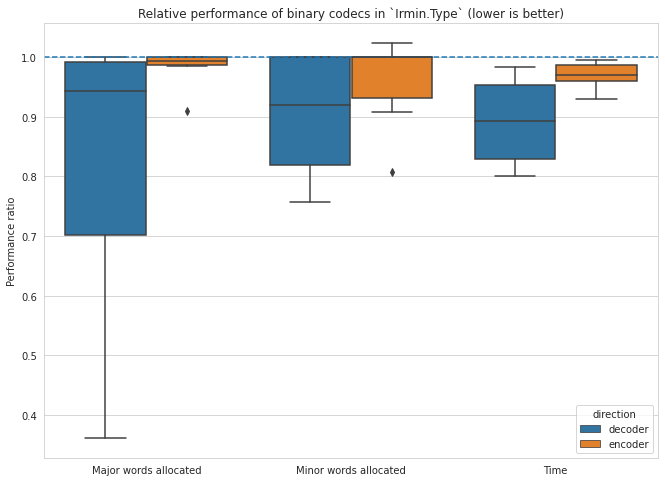

In [7]:
plot(sns.boxplot)

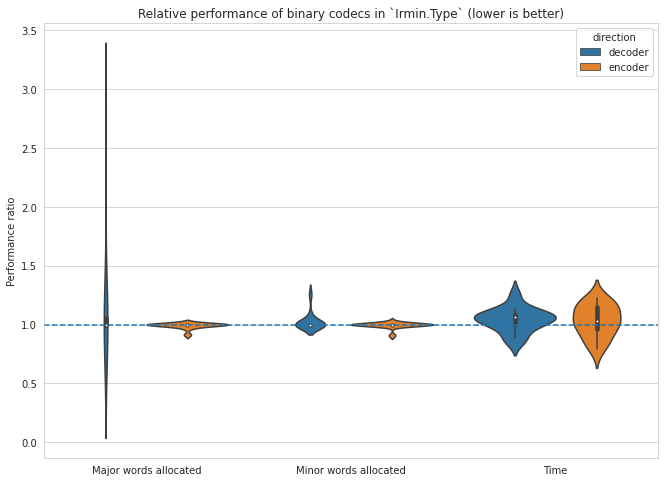

In [7]:
# NOTE: Violin-plot computes a side-distribution using kernel-density estimation (KDE).
#       KDE does not distribute over division, so this KDE is not statistically correct
#       for ratios of PDFs (as is the case here). Regardless, it gives some sense of the
#       underlying distributions hidden by the boxplot.

plot(sns.violinplot)

In [ ]:
sns.distplot(df[(df.variable == 'Time') & (df.direction == 'decoder')].value)
sns.distplot(df[(df.variable == 'Time') & (df.direction == 'encoder')].value)